# [Damped Oscillator - numba](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/do_nb.ipynb)

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/do_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pickle
import numpy as np
from tqdm import tqdm
from timeit import timeit
import sbi.utils as utils
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sbi.analysis import pairplot
from vbi.inference import Inference
from sklearn.preprocessing import StandardScaler
from vbi.models.numba.damp_oscillator import DO_nb

In [2]:
from vbi import report_cfg
from vbi import extract_features
from vbi import get_features_by_domain, get_features_by_given_names

In [3]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
params = {
    "a": 0.1,
    "b": 0.05,
    "dt": 0.05,
    "t_start": 0,
    "method": "heun",
    "t_end": 2001.0,
    "t_cut": 500,
    "output": "output",
    "initial_state": [0.5, 1.0],
}

In [5]:
if 0:
    ode = DO_nb(params)
    control = {"a": 0.11, "b": 0.06}
    t, x = ode.run(par=control)
    plt.figure(figsize=(4, 3))
    plt.plot(t, x[:, 0], label="$\\theta$")
    plt.plot(t, x[:, 1], label="$\omega$")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def func(par):
    ode = DO_nb(params)
    control = {"a": par[0], "b": par[1]}
    t, x = ode.run(par=control)
    return x

warm up

In [7]:
func([0.1, 0.05])
# timing
number = 1000
t = timeit(lambda: func([0.1, 0.05]), number=number)
print(f"average time for one run: {t / number:.5f} s")

average time for one run: 0.00861 s


In [8]:
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=["calc_std", "calc_mean"])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [9]:
def wrapper(params, control, cfg, verbose=False):
    ode = DO_nb(params)
    t, x = ode.run(par=control)

    # extract features
    fs = 1.0 / params["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[x.T], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values
    return stat_vec[0]

In [10]:
def batch_run(par, control_list, cfg, n_workers=1):
    def update_bar(_):
        pbar.update()
    stat_vec = []
    with Pool(processes=n_workers) as p:
        with tqdm(total=len(control_list)) as pbar:
            asy_res = [
                p.apply_async(wrapper, args=(par, control, cfg), callback=update_bar)
                for control in control_list
            ]
            stat_vec = [res.get() for res in asy_res]
    return stat_vec

In [11]:
control = {"a": 0.11, "b": 0.06}
x_ = wrapper(params, control, cfg)
print(x_)

[4.4408921e-16 2.2204460e-16 1.0530499e+00 8.8416451e-01]


In [12]:
num_sim = 200
num_workers = 10
a_min, a_max = 0.0, 1.0
b_min, b_max = 0.0, 1.0
prior_min = [a_min, b_min]
prior_max = [a_max, b_max]
theta_true = {"a": 0.1, "b": 0.05}

In [13]:
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [14]:
obj = Inference()
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)
control_list = [{"a": theta_np[i, 0], "b": theta_np[i, 1]} for i in range(num_sim)]

In [15]:
stat_vec = batch_run(params, control_list, cfg, n_workers=num_workers)

100%|██████████| 200/200 [00:00<00:00, 632.03it/s]


In [16]:
scaler = StandardScaler()
stat_vec_st = scaler.fit_transform(np.array(stat_vec))
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)
torch.save(theta, "output/theta.pt")
torch.save(stat_vec_st, "output/stat_vec_st.pt")

In [17]:
theta.shape, stat_vec_st.shape

(torch.Size([200, 2]), torch.Size([200, 4]))

In [18]:
posterior = obj.train(
    theta, stat_vec_st, prior, num_threads=8, method="SNPE", density_estimator="maf"
)

 Neural network successfully converged after 409 epochs.train Done in 0 hours 0 minutes 17.764631 seconds


In [19]:
with open("output/posterior.pkl", "wb") as f:
    pickle.dump(posterior, f)

In [20]:
with open("output/posterior.pkl", "rb") as f:
    posterior = pickle.load(f)

/home/ziaee/anaconda3/envs/vbi_paper/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [21]:
xo = wrapper(params, theta_true, cfg)
xo_st = scaler.transform(xo.reshape(1, -1))

In [22]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
torch.save(samples, "output/samples.pt")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

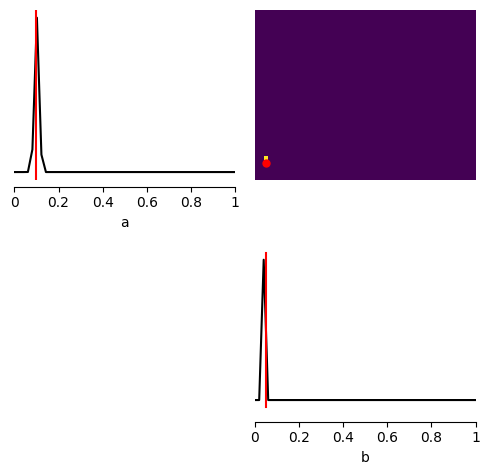

In [23]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    points=[list(theta_true.values())],
    figsize=(5, 5),
    limits=limits,
    labels=["a", "b"],
    offdiag="kde",
    diag="kde",
    points_colors="r",
    samples_colors="k",
    points_offdiag={"markersize": 10},
)
ax[0, 0].margins(y=0)
plt.tight_layout()
fig.savefig("output/tri_do_nb.jpeg", dpi=300)